In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from lib.sampling import get_slides
from data_loader import *
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet
import sys
sys.path.append('../')

size=256
path = Path('../')

database = Database()
database.open(str(path/'AblationStudy/databases/MITOS_WSI_CMCT_ODAEL_5HPF.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

In [3]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database, basepath='images/5HPF/')
            

Convert database into in-memory object

In [5]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [6]:
bs = 32 
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


In [7]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [8]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

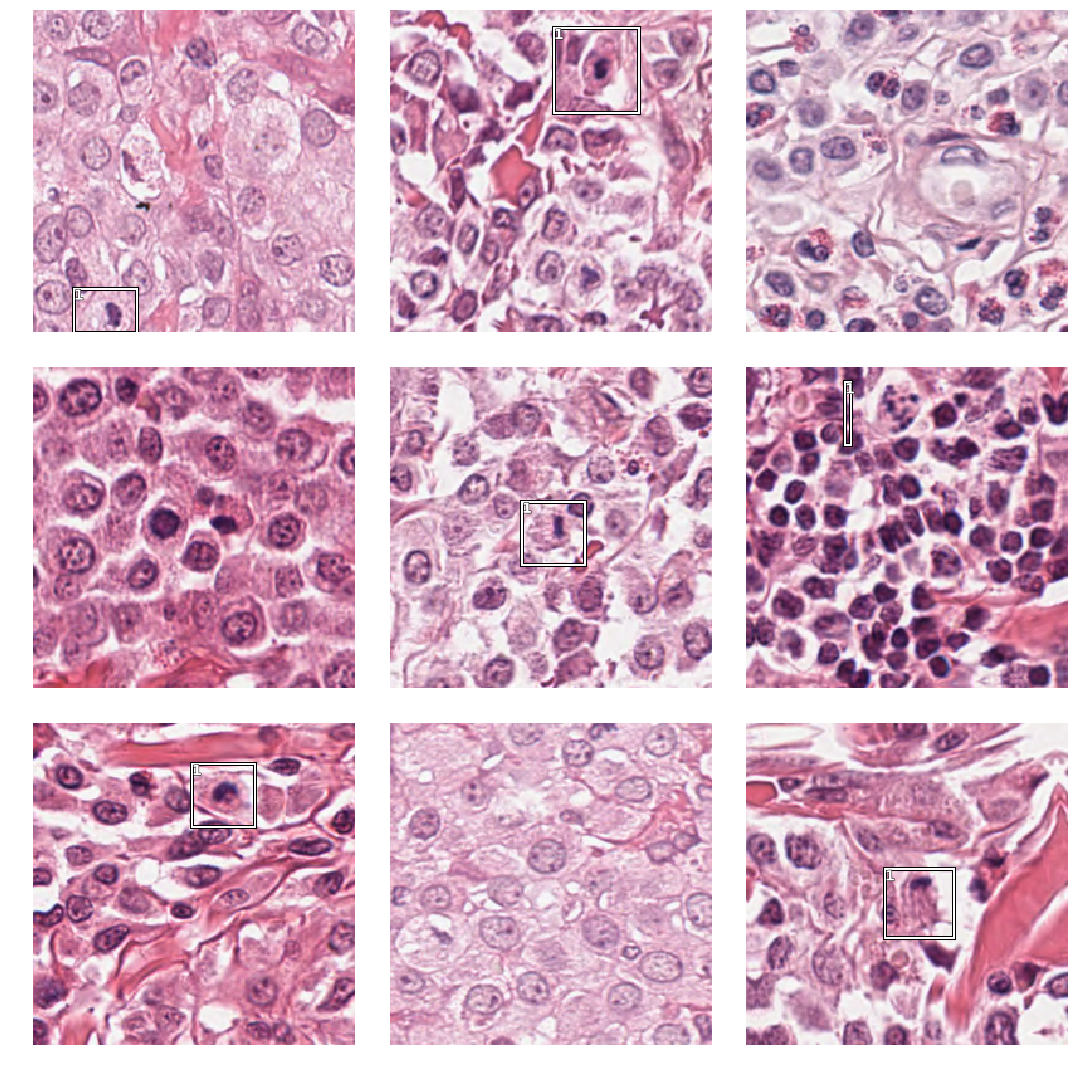

In [9]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [10]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


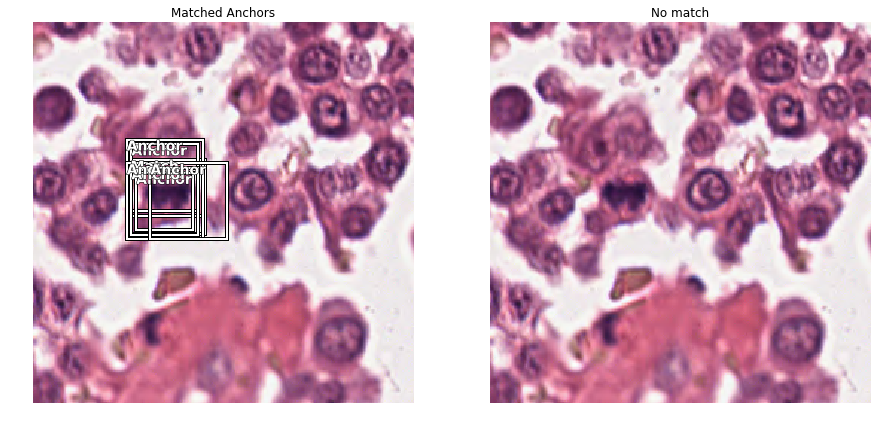

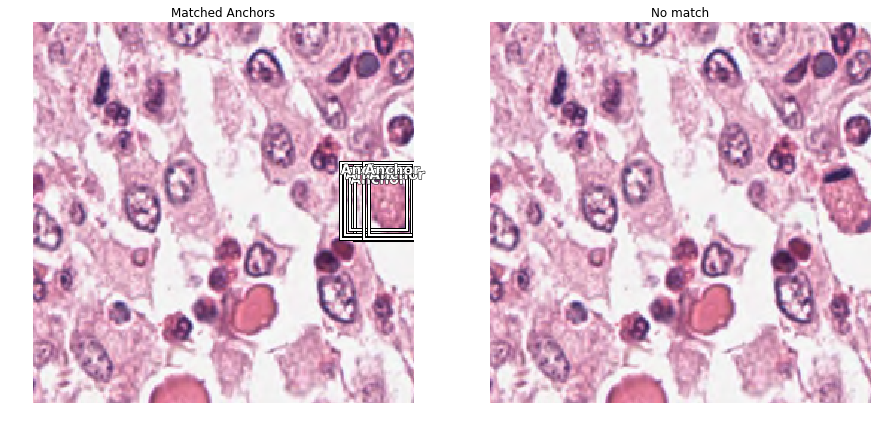

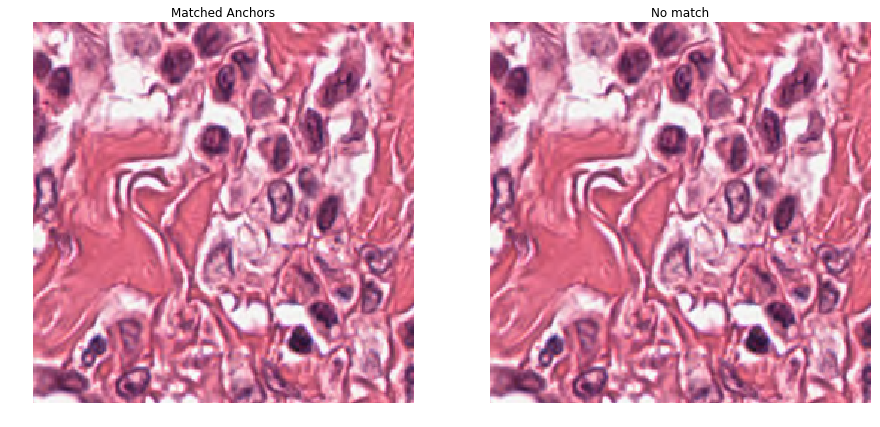

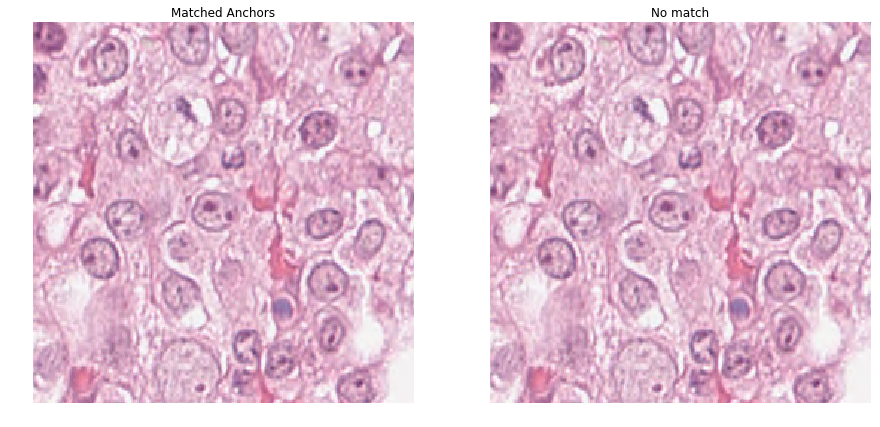

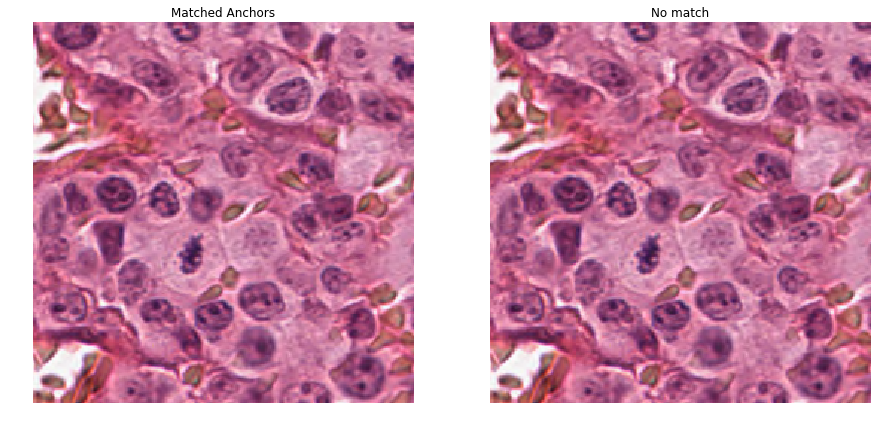

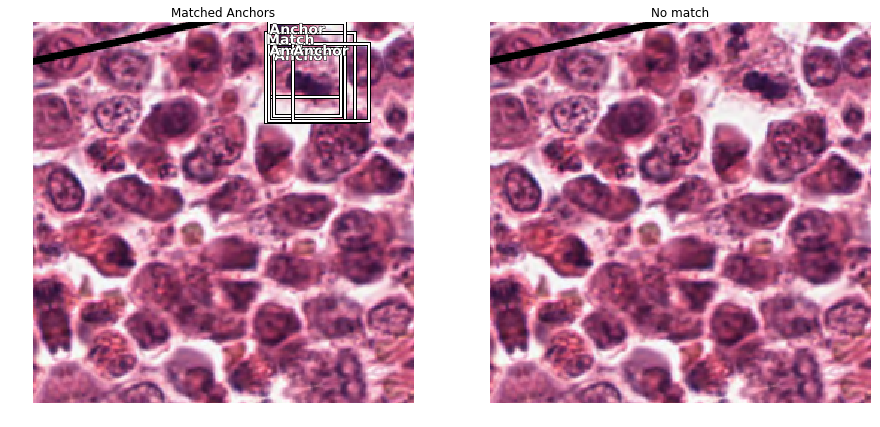

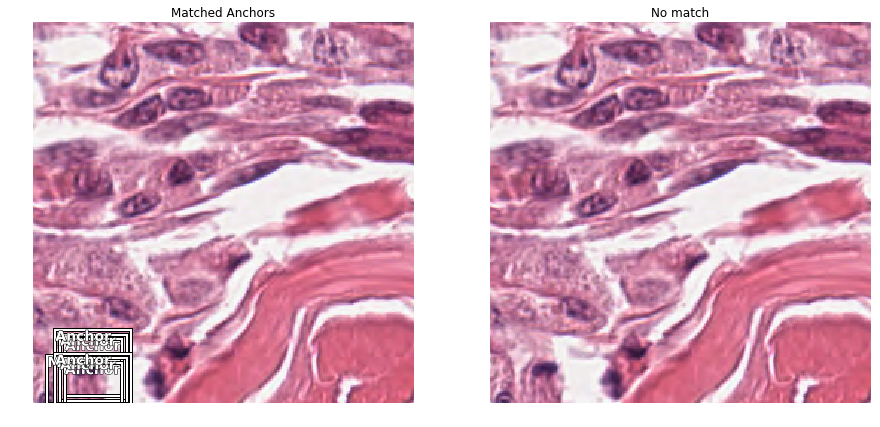

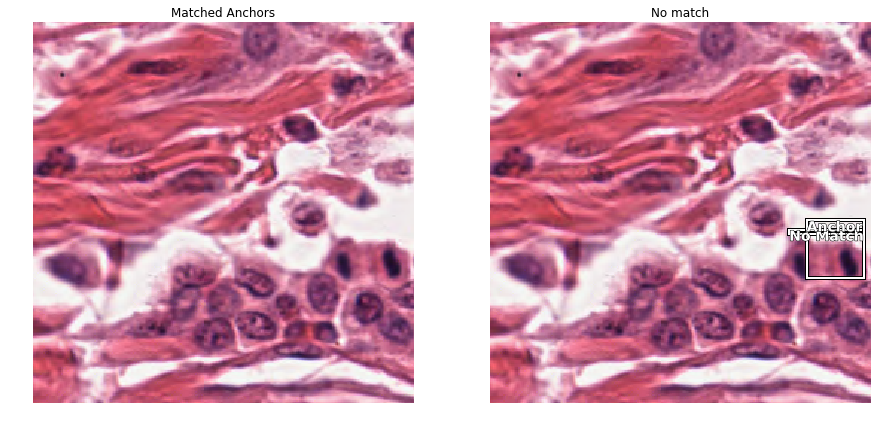

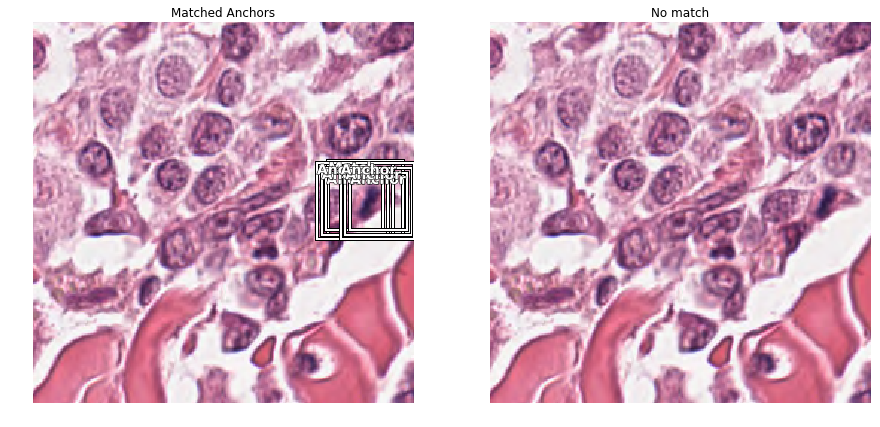

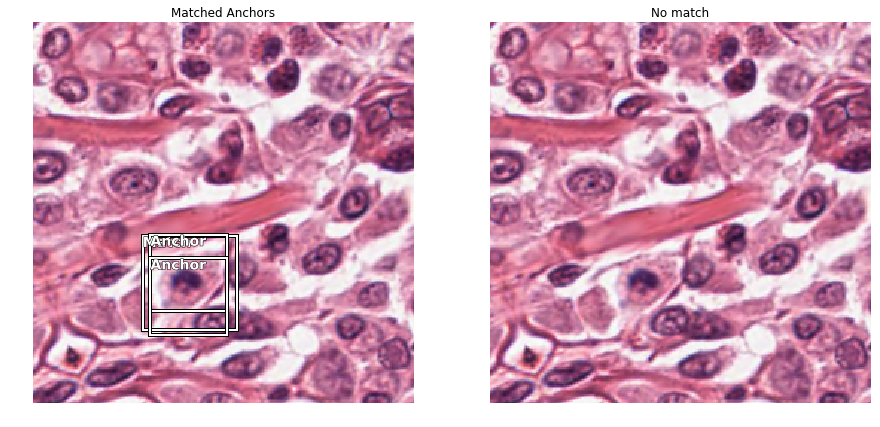

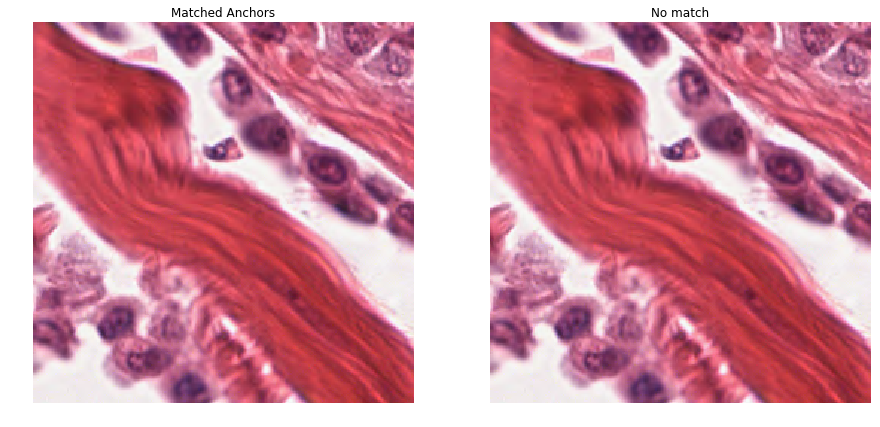

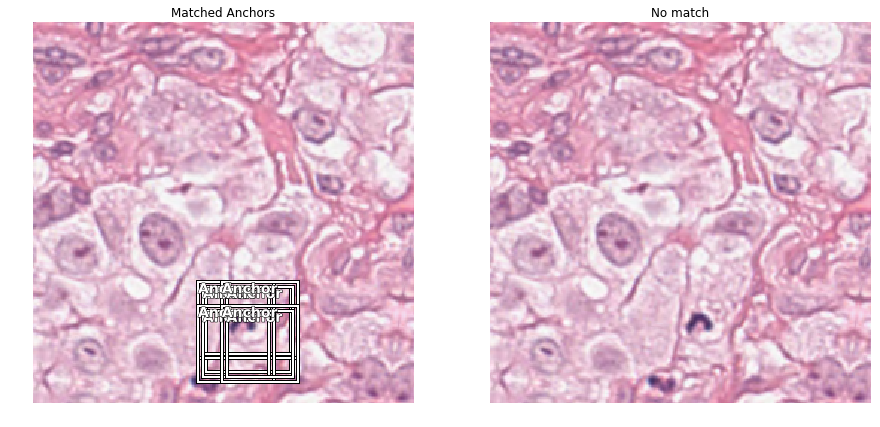

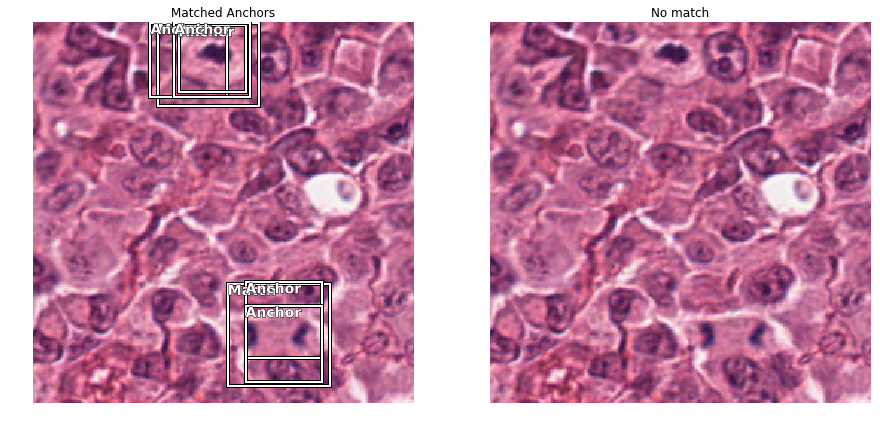

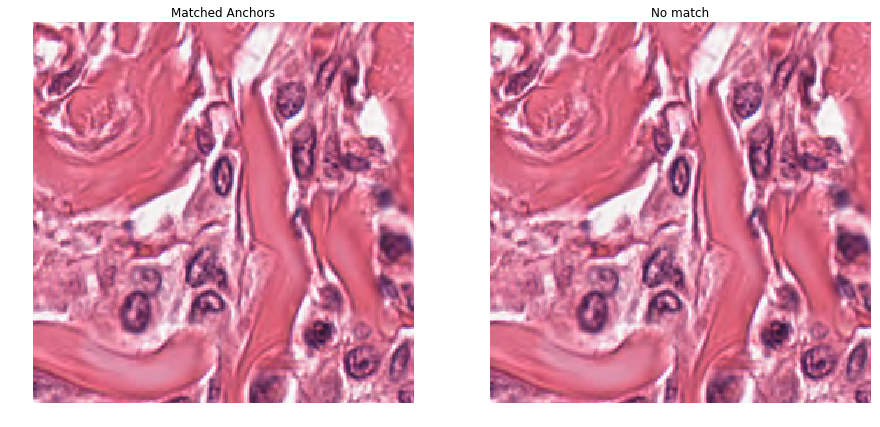

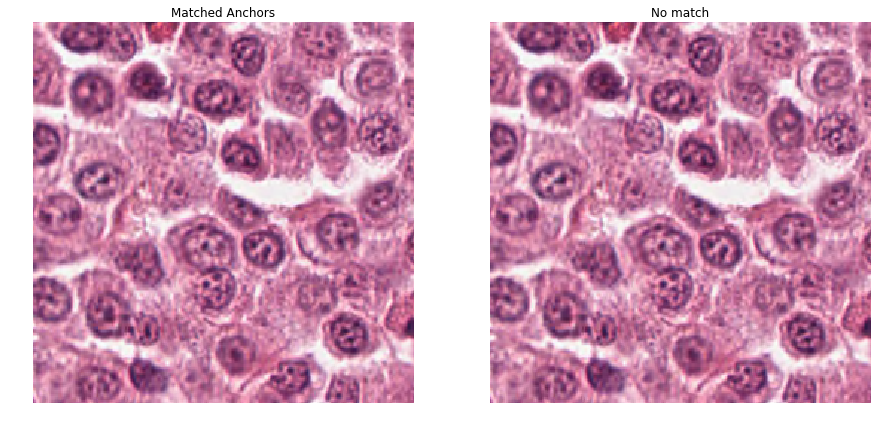

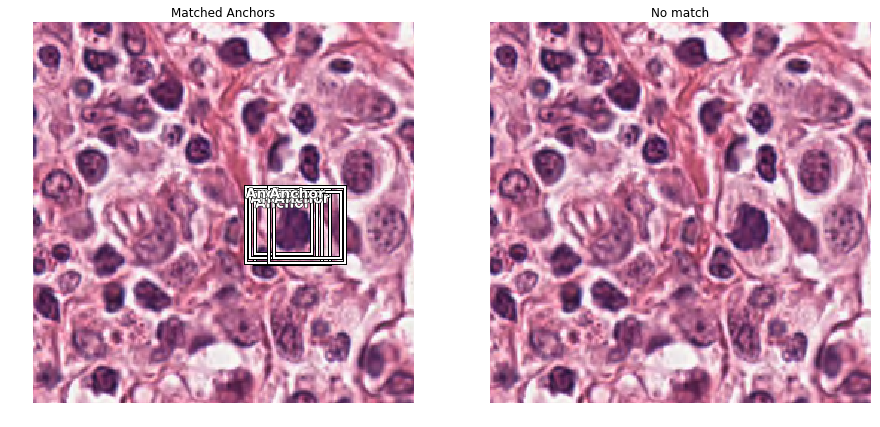

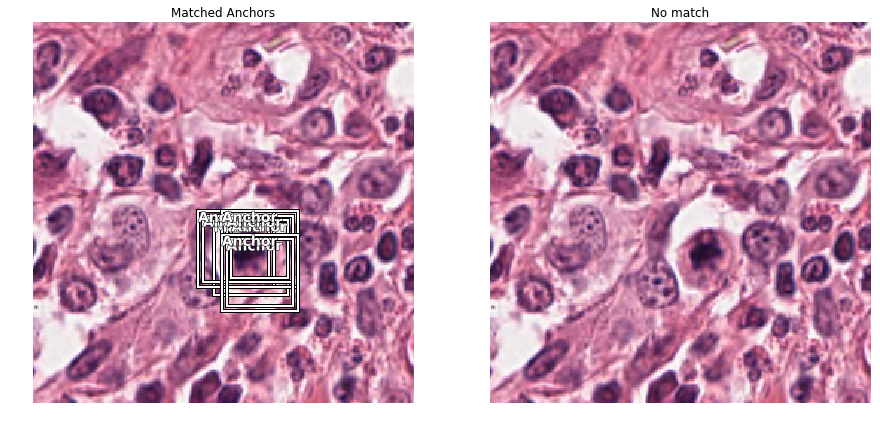

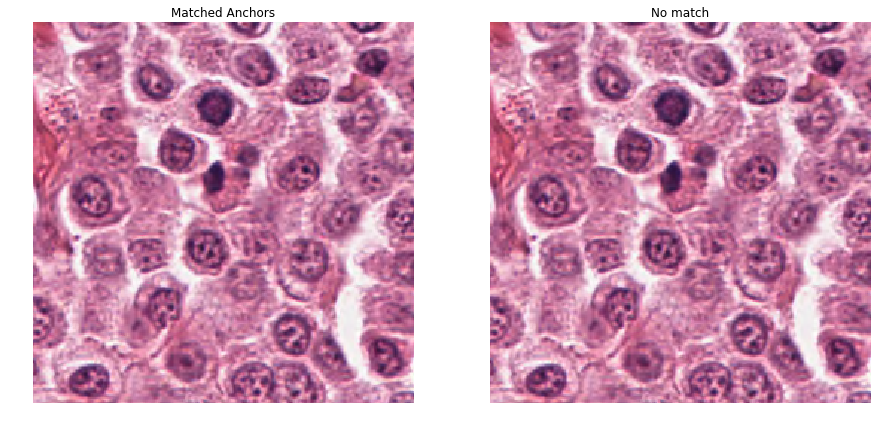

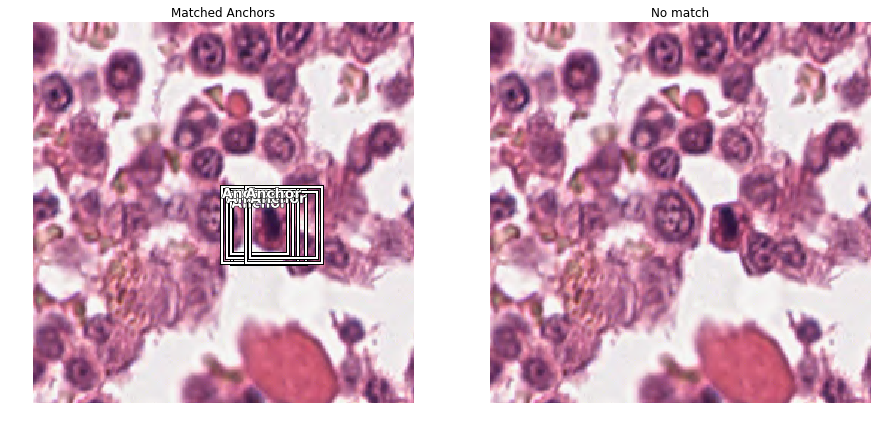

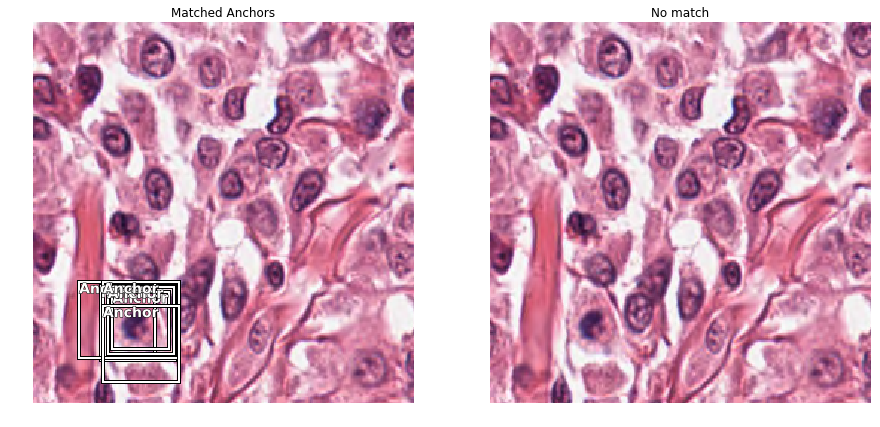

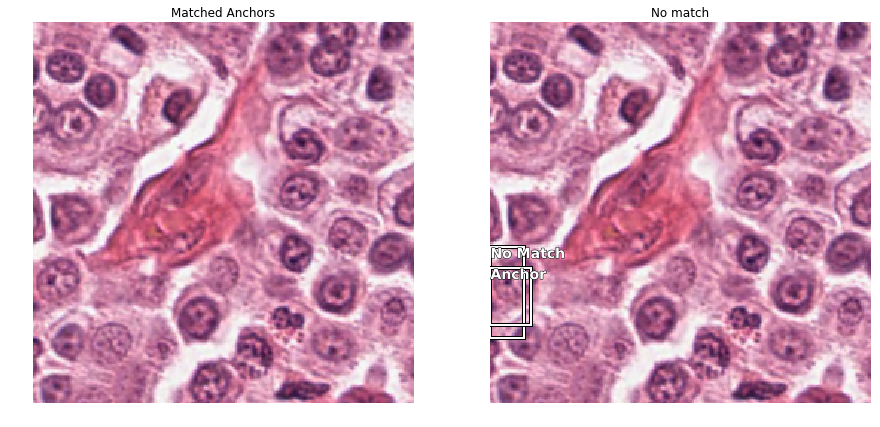

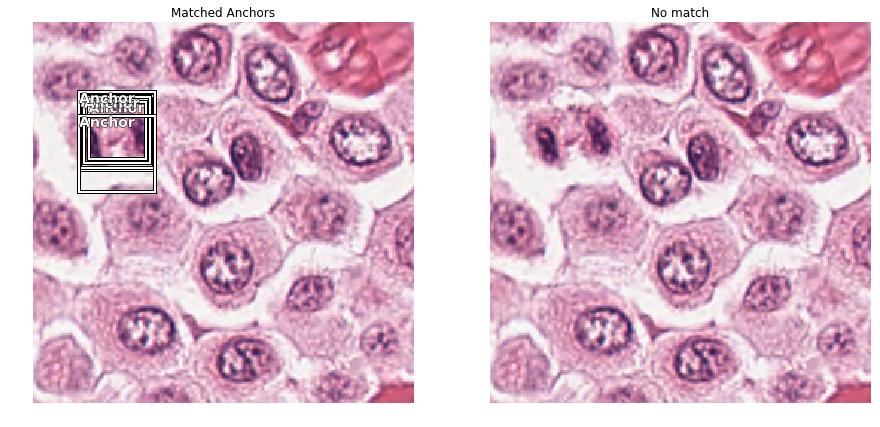

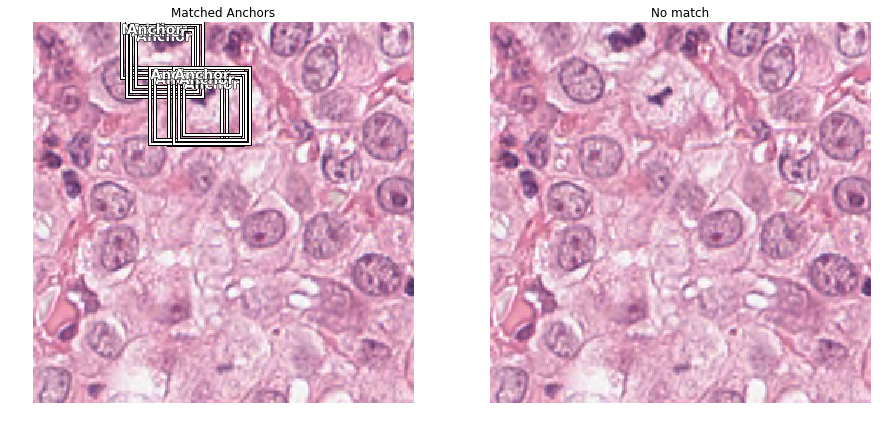

In [11]:
not_found = show_anchors_on_images(data, anchors)

In [12]:
crit = RetinaNetFocalLoss(anchors)

In [13]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [14]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [15]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


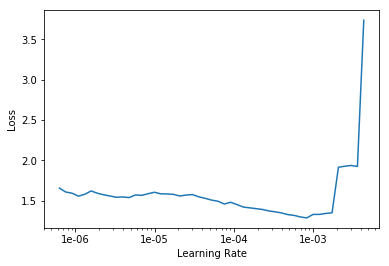

In [16]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1505/1505 [00:00<00:00, 5180.04it/s]


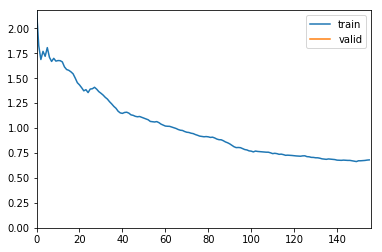

In [17]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 1452/1452 [00:00<00:00, 7024.66it/s]


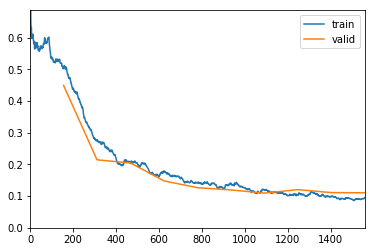

GT: 100%|██████████| 2076/2076 [00:00<00:00, 4770.90it/s]


In [18]:
lr=1e-4
learn.unfreeze()

learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

In [19]:
lr=1e-4

#for k in range(3):
#    learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 1994/1994 [00:00<00:00, 5639.07it/s]


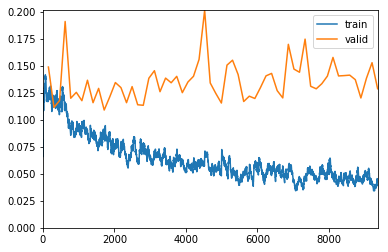

Better model found at epoch 0 with pascal_voc_metric value: 0.8403842448680818.


GT: 100%|██████████| 1898/1898 [00:00<00:00, 5758.11it/s]


Better model found at epoch 3 with pascal_voc_metric value: 0.847439817947652.


GT: 100%|██████████| 2072/2072 [00:00<00:00, 4863.34it/s]


Better model found at epoch 17 with pascal_voc_metric value: 0.8534047547606335.


GT: 100%|██████████| 2085/2085 [00:00<00:00, 4409.73it/s]


Better model found at epoch 22 with pascal_voc_metric value: 0.8730301959585248.


GT: 100%|██████████| 2013/2013 [00:00<00:00, 4815.41it/s]


In [20]:
learn.unfreeze()
lr=1e-4

learn.fit(60, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

In [21]:
#learn.save('RetinaNet-ODAEL-small-ave-2.pth', with_opt=True) 
#learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

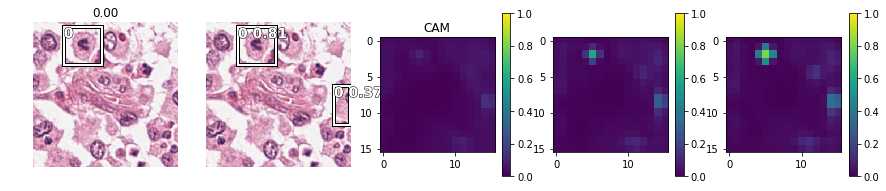

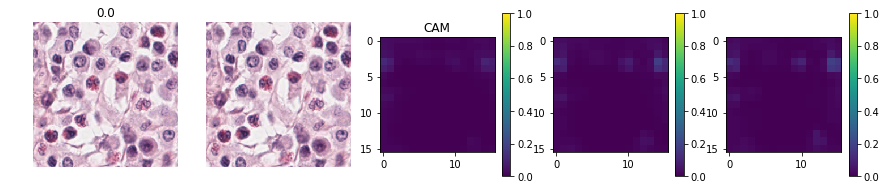

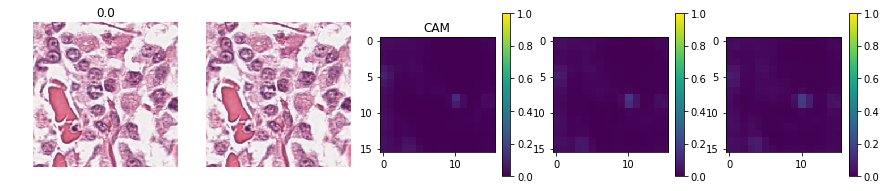

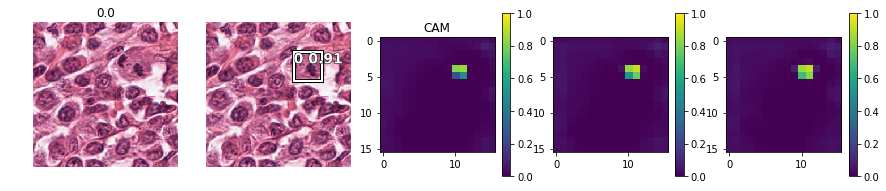

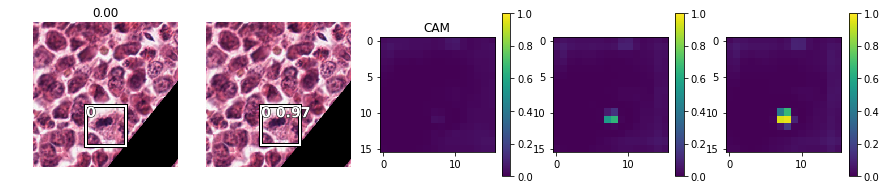

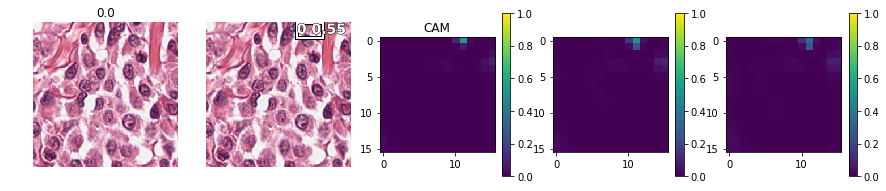

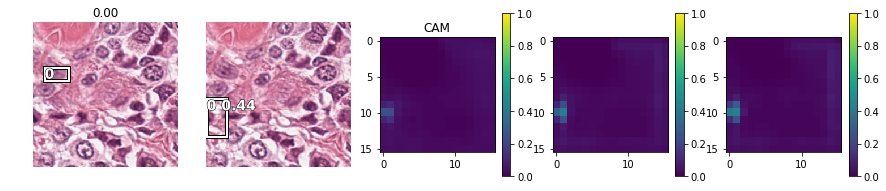

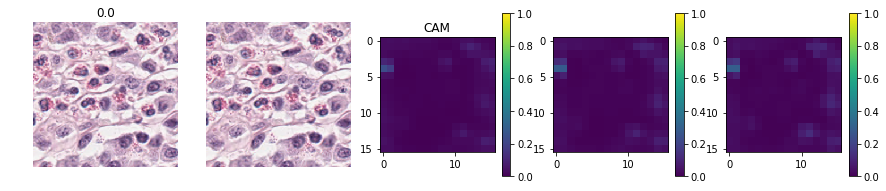

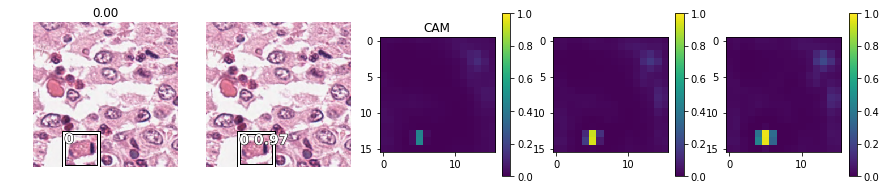

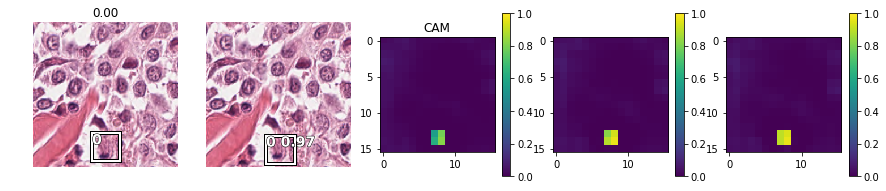

In [22]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [23]:
learn.save('RetinaNe-ODAEL-5HPF-save.pth', with_opt=True)
learn.export("RetinaNet-ODAEL-5HPF-export.pth")